# Problema de regresión

<font color='blue'>El objetivo es identificar un modelo que nos permita predecir, con los datos proporcionados y consumiendo la menor cantidad de recuros posible, el precio (price) de un diamante a partir de un conjunto de propiedades físicas del mismo</font>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns             #Para realizar gráficas
import matplotlib.pyplot as plt   #Para algunos parámetros de las gráficas
import graphviz
from matplotlib.colors import ListedColormap # Para utilizar un mapa de color
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR


#Para visualizar las gráficas en el notebook
%matplotlib inline  
%precision

# Mapa de color
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Análisis exploratorio

<font color='blue'>El primer paso es la carga de datos y una rápida visualización del número de muestras y características, así como "un primer vistazo" a los datos que obtenemos.</font>

In [3]:
datos = pd.read_csv("./diamonds.csv", sep=",")
print('Num. de muestras: ', datos.shape[0])
print('Características:', datos.shape[1])
datos.head()

Num. de muestras:  53940
Características: 11


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


<font color='blue'>El siguiente paso es entender la tipología (datos.dtypes) de las características objeto de estudio (aunque en este caso disponemos de información previa en el enunciado del ejercicio) y para ello analizamos los valores únicos de las distintas características.</font>

In [4]:
print('cut : ' , list(datos['cut'].unique()))
print('--------------------------------------------------------------------------------------------')
print('color : ' , list(datos['color'].unique()))
print('--------------------------------------------------------------------------------------------')
print('clarity : ' , list(datos['clarity'].unique()))

cut :  ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
--------------------------------------------------------------------------------------------
color :  ['E', 'I', 'J', 'H', 'F', 'G', 'D']
--------------------------------------------------------------------------------------------
clarity :  ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']


<font color='blue'>Veamos la descripción global de los distintos datos. En este caso vemos que no existen NA ya que el campo "count" se corresponde con el núero total de muestras para todas las características, pero en el caso de no estar seguros de la existencia de NA utilizaríamos datos.isna().sum()</font>

In [5]:
datos.describe(include='all')

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940,53940,53940,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,21551,11292,13065,NaN,NaN,NaN,NaN,NaN,NaN
mean,26970.500000,0.797940,NaN,NaN,NaN,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,NaN,NaN,NaN,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,NaN,NaN,NaN,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,NaN,NaN,NaN,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,NaN,NaN,NaN,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,NaN,NaN,NaN,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000


# Procesamiento

<font color='blue'>Eliminamos 'Unnamed: 0' ya que es un índice y no aporta información.</font>

In [6]:
datos = datos.drop(['Unnamed: 0'], axis=1)

<font color='blue'>Para poder manejar y analizar mejor las variables categóricas vamos a transformarlas a numéricas</font>

In [7]:
le = LabelEncoder()
datos['cut'] = le.fit_transform(datos['cut'])
datos['color'] = le.fit_transform(datos['color'])
datos['clarity'] = le.fit_transform(datos['clarity'])

datos.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


<font color='blue'>Tras los cambios realizados es conviene siempre hacer representaciones gráficas que nos ofrecen, en general, un mejor entendimiento de los datos. Para ello, y dado que todas las características son numéricas, vamos representar los histogramas de las mismas.</font>

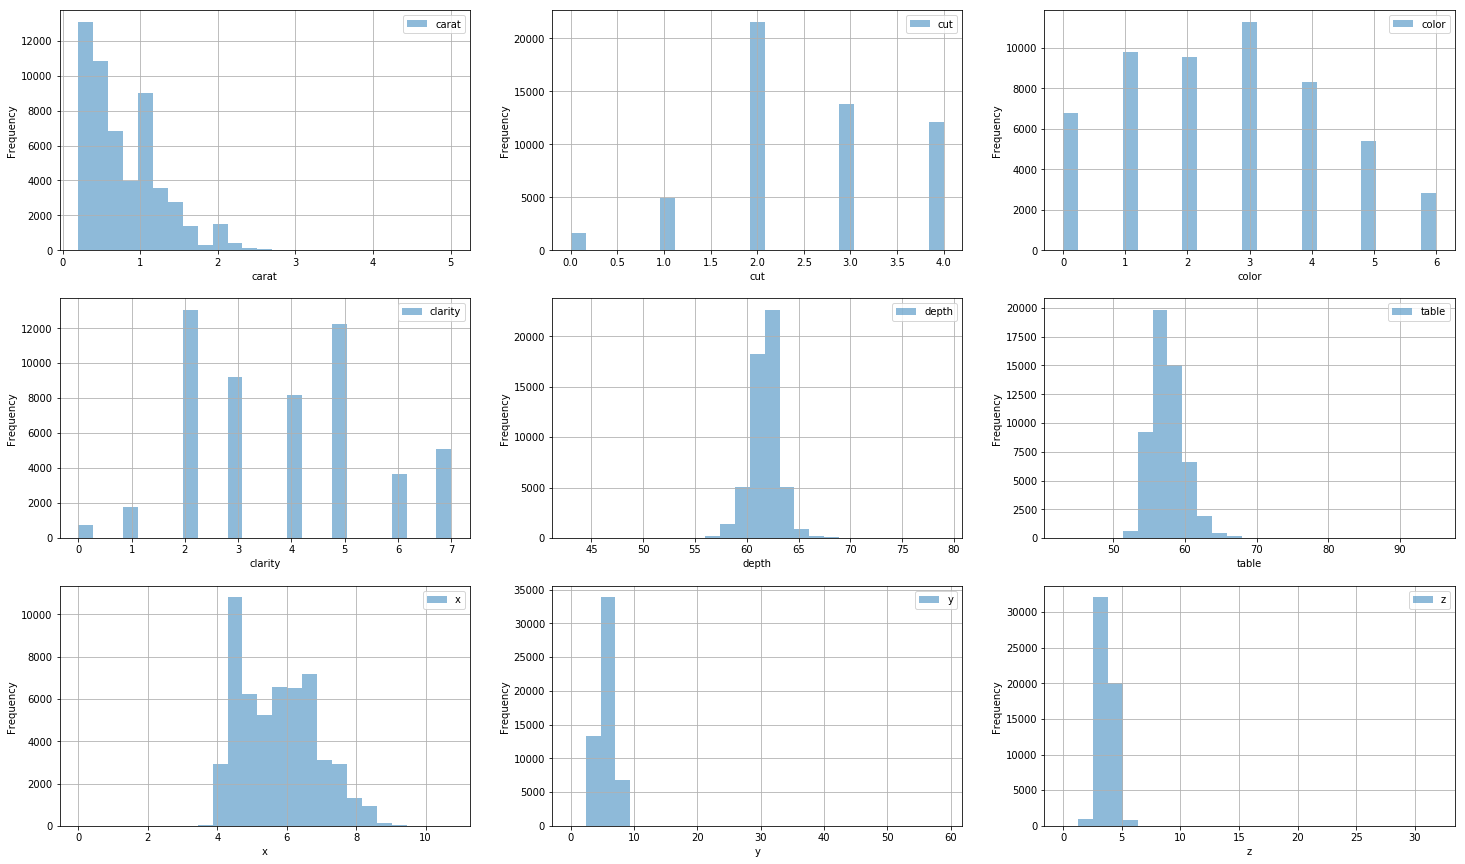

In [8]:
plt.figure(figsize=(25,15))
for i,feature in enumerate(datos.columns.drop(['price'])):
    plt.subplot(3,3,i+1)   
    datos[feature].plot.hist(alpha=0.5, bins=25, grid = True)
    plt.xlabel(feature)
    plt.legend()
    #plt.title(feature)
plt.show()

<font color='blue'>A partir del histograma no veo nada particular que me permita tomar más decisiones en éste momento. No he dibujado el histograma en relación a la característica que nos interesa ya que al no ser categórica no creo que su representación ayude en el análisis</font>

## Correlación de datos

<font color='blue'>Podríamos calcular la matriz de correlación, con valores entre [-1,1] y un gradiente de color, pero la verdad no parece la mejor forma de sacar conclusiones, así que otra forma mejor de verlo es con un intervalo entre [0,1] y eliminando la mitad superior de los datos ya que son redundantes, así como la diagonal que es 1.</font>

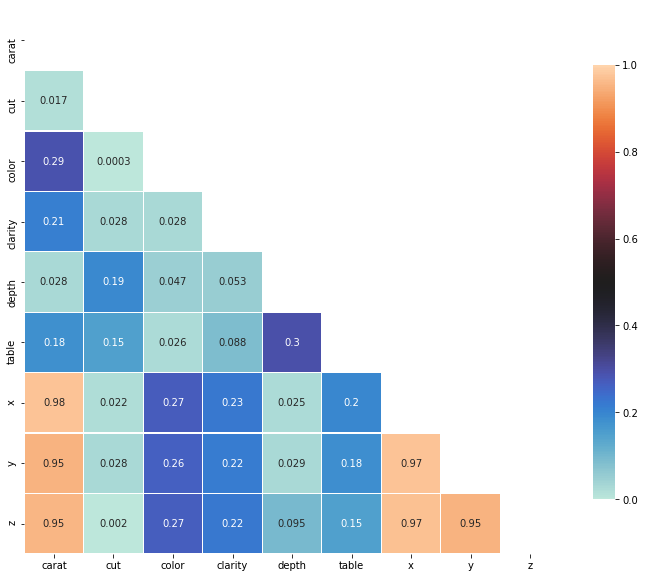

In [9]:
# Compute the correlation matrix
corr = np.abs(datos.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, annot=True, cbar_kws={"shrink": .8})

plt.show()

<font color='blue'>La característica 'carat', que equivale al peso del diamante, tiene un alto grado de correlacionado con las características 'x', 'y' y 'z'. Además, estas últimas tienen un alto grado de correlación entre ellas por lo que las eliminamos y nos quedasmos con 'carat'. </font>


In [10]:
datos = datos.drop(columns=['x','y','z'], axis=1)

<font color='blue'>Vamos a analizar las distintas características que quedan de forma individual.</font>

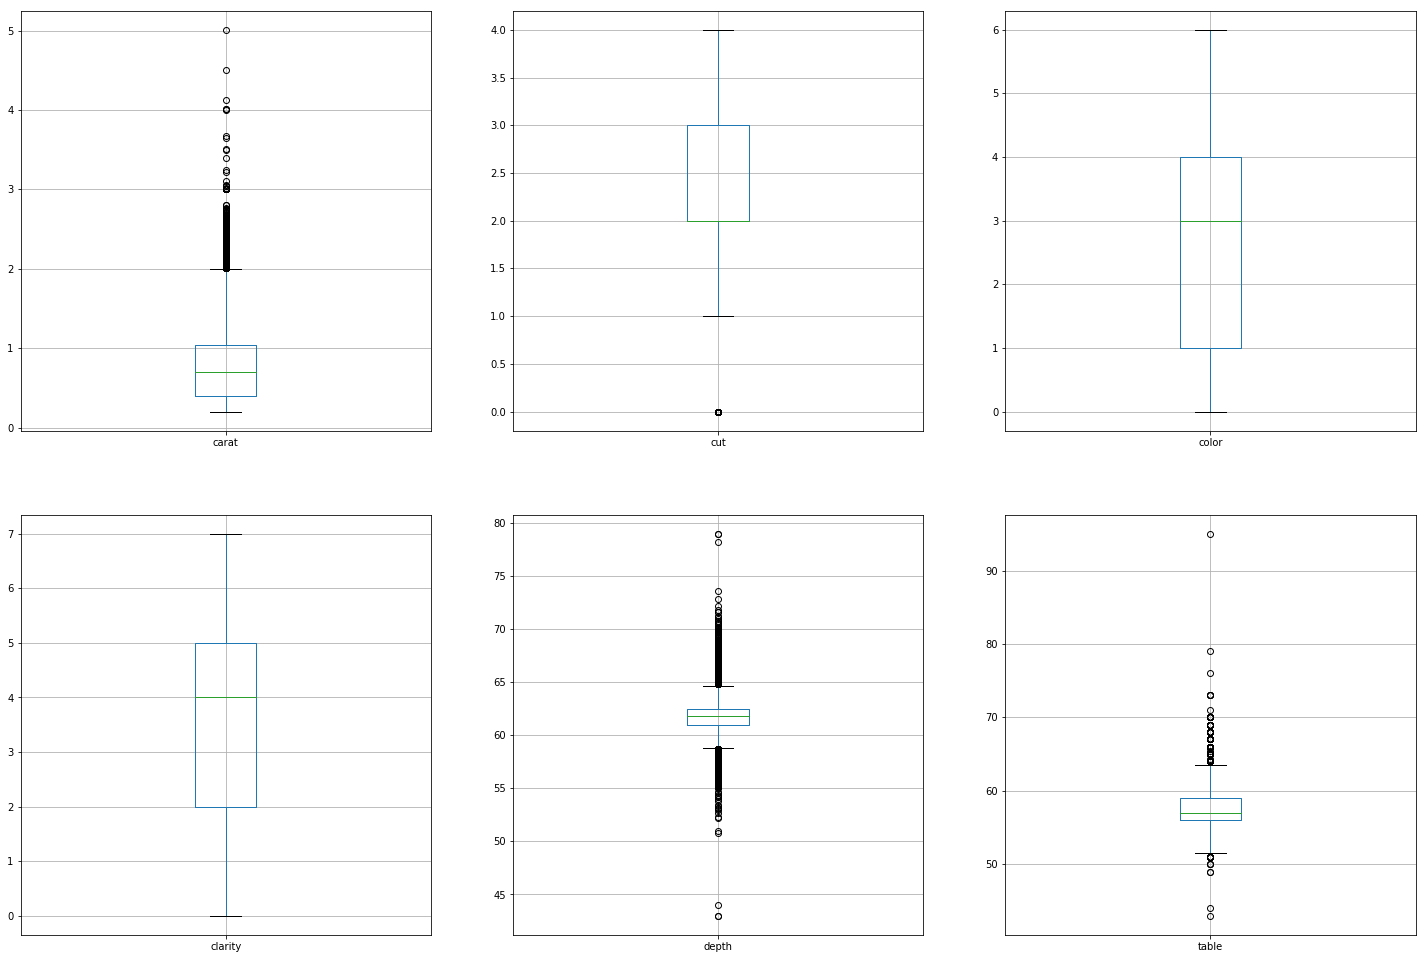

In [11]:
plt.figure(figsize=(25, 17))

for i,feature in enumerate(datos.columns.drop(['price'])):
    plt.subplot(2,3,i+1)
    datos.boxplot(column=feature)

plt.show()

<font color='blue'>No parece que las características restantes requieran de un trato adicional. Si bien aparecen outlayers en elgunos casos, su volumen no creo que afecte al análisis.</font>

<font color='blue'>Adicionalmente, creamos el histograma de distribución de las caractrísiticas (que ahora son todas numéricas) con valores no normalizados (para normalizarlos hay que reasignar "density=1") en relación a la caracterísitica que nos interesa "price"</font>

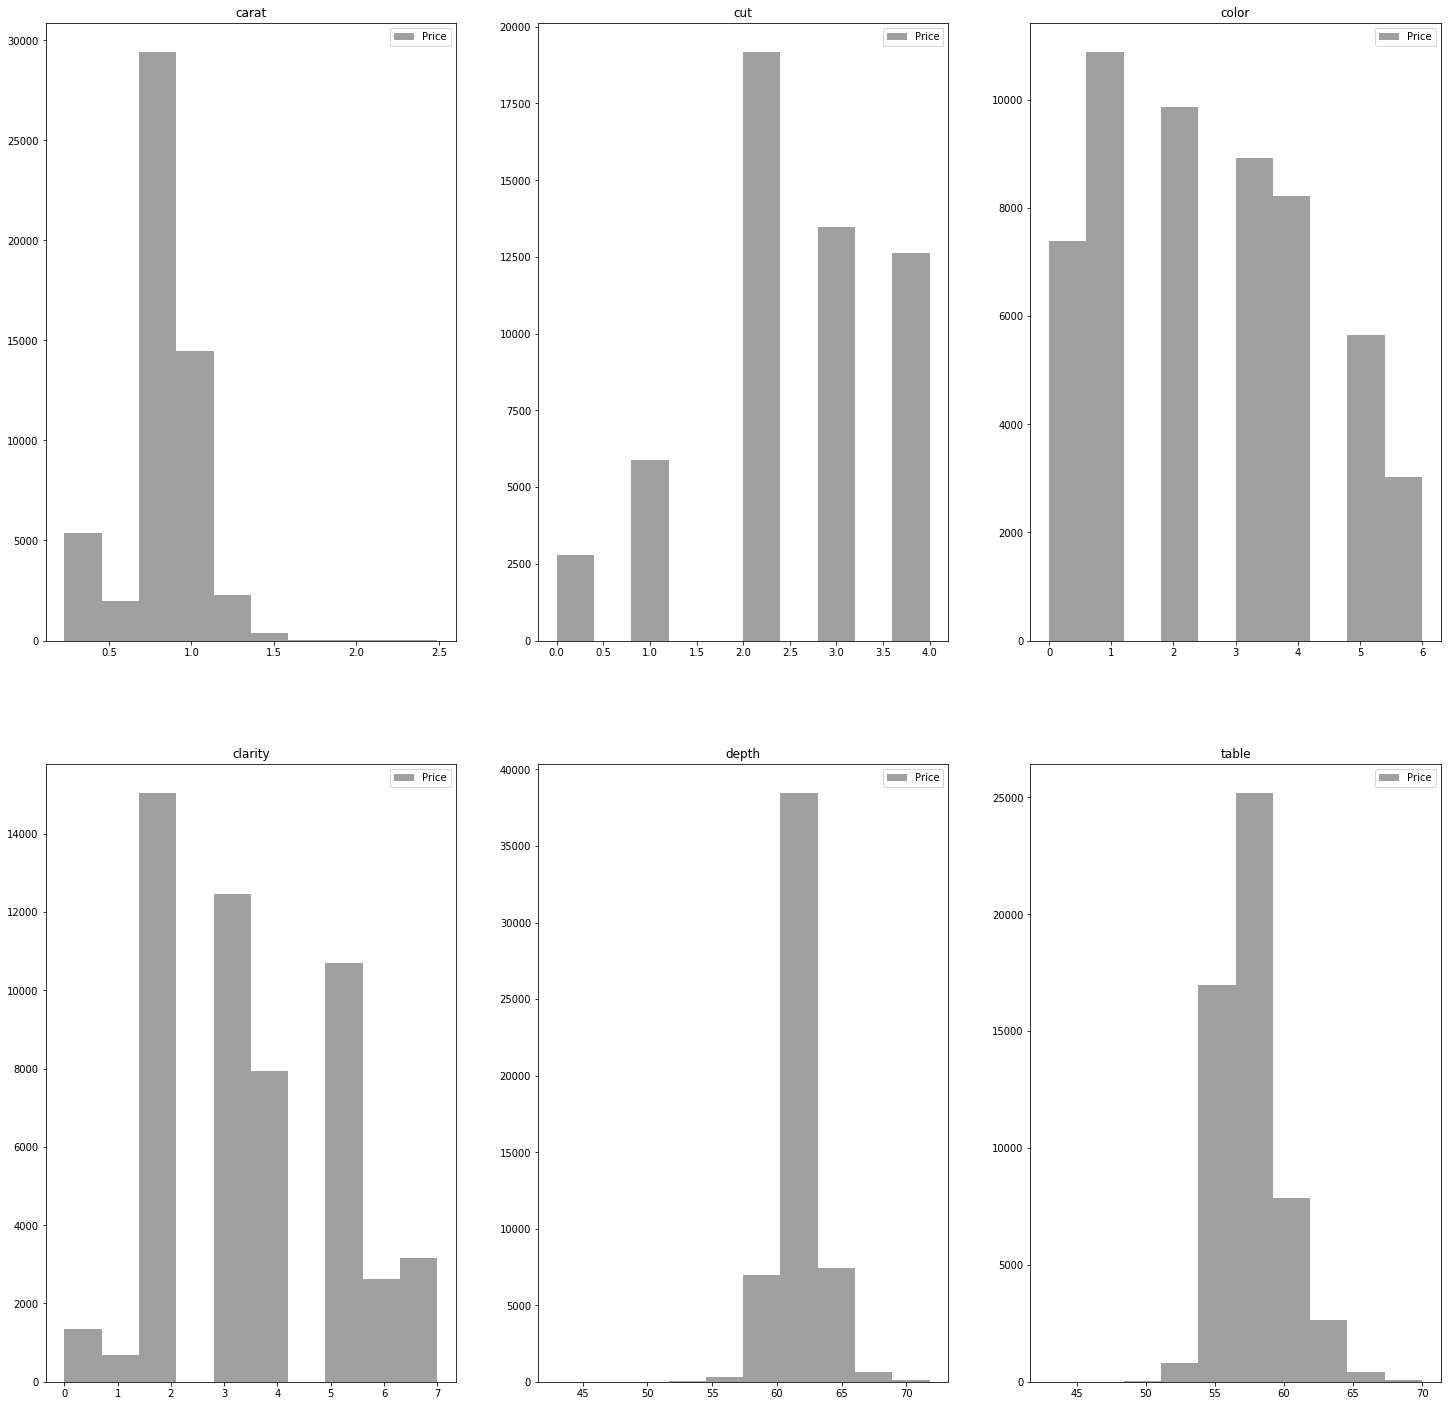

In [12]:
plt.figure(figsize=(25,25))
idx =  datos['price']

for i,feature in enumerate(datos.columns.drop(['price'])):
    plt.subplot(2,3,i+1)   
    plt.hist(datos.loc[idx,feature],density=0, facecolor='grey', alpha=0.75,label='Price')
    plt.legend()
    plt.title(feature)

plt.show()

<font color='blue'>No identifico nada que me haga pensar que puedo eliminar alguna de ls características restantes en relación al coste</font>

## Métricas en clasificación

### División train/test 

<font color='blue'>En este punto empezamos a trabajar con los datos que hemos analizado y tratado.
    
Dividimos en los grupos de test (75%) y train (25%) y estratificamos (stratify = y) para tener la misma proporción en ambos conjuntos de valores de 'income' tanto por encima, como por debajo de 50k.

Posteriormente escalamos los datos, ya que en algunos modelos es una acción necesaria.</font>

In [14]:
columns_to_drop = []
columns_to_drop.append('price')
features = datos.columns.drop(columns_to_drop)

X = datos[features].values
y = datos['price'].values

# PASO 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

# Escalamos (con los datos de train)
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))

Datos train:  (40455, 6)
Datos test:   (13485, 6)
Propocion train:3928.059
Propocion test: 3947.022


### Ridge regresion

Utilizamos el modelo de regresión lineal con penalización sobre la magnitud de los coeficientes como medida contra el [*overfitting*](https://en.wikipedia.org/wiki/Overfitting)

El modelo de [*ridge regression*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), tiene un parámetro libre ($\alpha$) que hay de fijar a priori para que el modelo calcule los coeficientes $\boldsymbol{\omega}$. A tener en cuenta:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

Por tanto, para buscar el valor de $\alpha$ adecuado, tendremos que barrer valores en una escala (para lo que utilizaremos "alpha_vector", un vector de 50 elemento entre [0.1,100] o $[10^{-1},10^{2}]$) que cubra valores muy pequeños y valores elevados. Para ello, normalmente se utiliza escala logarítmica aumentando progresivamente el orden  de magnitud.

Vamos a implementar el algoritmo de *ridge regression* variando los valores de $\alpha$, y viendo cómo esta variación afecta a los coeficientes $\boldsymbol{\omega}$ del modelo. Para identificar el mejor valor de $\alpha$ utilizamos la validación cruzada. 

best mean cross-validation score: -1910186.741
best parameters: {'alpha': 2.2229964825261943}


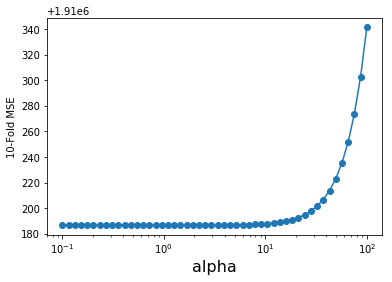

In [20]:
alpha_vector = np.logspace(-1,2,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

<font color='blue'>Entrenamos el modelo ahora con el valor óptimo de $\alpha$ que hemos encontrado con validación cruzada.</font>

In [23]:
alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo).fit(Xs_train,y_train)

# predicción
y_hat = ridge.predict(Xs_test)
w = ridge.coef_

mse_Ridge = mean_squared_error(y_test,y_hat)
print('MSE Modelo Ridge (test) : %0.3g' % mse_Ridge)

for f,wi in zip(datos.drop(columns=['price']).columns,w):
    print(f,wi)

MSE Modelo Ridge (test) : 1.89e+06
carat 3953.68727293
cut 77.4369077324
color -435.365116969
clarity 520.478430036
depth -154.677347287
table -217.665175784


<font color='blue'>No hay ninguna característica que se haga 0, por lo que lo que podemos inferir del modelo es que "carat" es la caractrística con mayor influencia en el coste, dado que su valor es mayor que el resto.</font>

## Algoritmo de Lasso

<font color='blue'>Ahora vamos a utilizar Lasso para seleccionar variables</font>

El algoritmo Lasso permite activar/desactivar coeficientes, de tal forma que se desactivan primero los coeficienes asociados a los atributos que menos influyen en la función de coste (función a minimizar anterior). Con ello:

1. Se previene el overfitting, al poder utilizar modelos con menos variables (las desactivamos)
2. Se gana interpretabilidad, al poder ver cómo evolucionan las variables supervivientes.

La activación y desactivación de variables está determinada por el parámetro de regularización $\alpha$, de la misma forma que sucede con el algoritmo Ridge. Para buscar el valor de $\alpha$ adecuado, tendremos que barrer valores en una escala (para lo que utilizaremos "alpha_vector", un vector de 50 elemento entre [$[10^{-1},10^{10}]$) que cubra valores muy pequeños y valores elevados. Para ello, normalmente se utiliza escala logarítmica aumentando progresivamente el orden  de magnitud.


best mean cross-validation score: -1910186.811
best parameters: {'alpha': 0.10000000000000001}


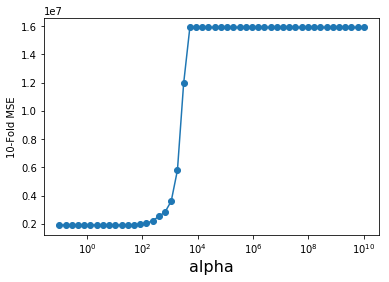

In [25]:
alpha_vector = np.logspace(-1,10,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [26]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(Xs_train,y_train)

ytestLasso  = lasso.predict(Xs_test)
mse_Lasso = mean_squared_error(y_test,ytestLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mse_Lasso)

w = lasso.coef_
for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (test) : 1.89e+06
carat 3953.7806865
cut 77.3539849155
color -435.32654091
clarity 520.448956869
depth -154.57357999
table -217.5541303


<font color='blue'>De nuevo, no hay ninguna característica que se haga 0, por lo que lo que podemos inferir del modelo es que "carat" es la caractrística con mayor influencia en el coste, dado que su valor es mayor que el resto.</font>

### Arbol de decision

<font color='blue'>Lo primero es identificar el mejor valor para el parámetro "max_depth", la profundidad máxima a la que vamos a llegar a la hora de desarollar el arbol, para lo que utilizamos CV.</font>

best mean cross-validation score: 0.975
best parameters: {'max_depth': 11}


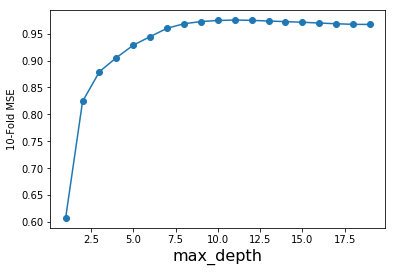

In [27]:
maxDepth = range(1,20)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

<font color='blue'>Nos vamos a centrar en el valor de accuracy para las muestras de test, y para ello utilizamos el valor de "max_depth" optimo obtenido en el paso anterior.</font>

In [28]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(Xs_train,y_train)

print("Test: ",treeModel.score(Xs_test,y_test))

Test:  0.97484932421


<font color='blue'>El valor obtenido es muy bueno, por lo que podrámos dejarlo aquí. Vamos a ver la gráfica comparativa entre los valores predichos y los reales:</font>

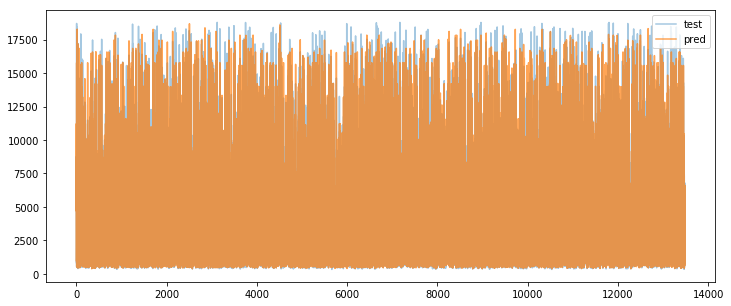

In [29]:
ytestTree = treeModel.predict(Xs_test)

plt.figure(figsize=(12,5))

plt.plot(y_test,label='test',alpha=0.4)
plt.plot(ytestTree,label='pred',alpha=0.7)
plt.legend()
plt.show()

<font color='blue'>En este modelo el error es muy bajo tal y como podemos ver por la puntuación (.score). 
    
La gráfica para el conjunto de test evidencia que el precio que predice el modelo se ajusta realmente bien al precio real.
  
Pero vamos a compararlo con otros modelos como parte de la práctica.</font>

<font color='blue'>Podríamos graficar el árbol mediante el siguiente código:</font>
<font color='green'>
    
    dot_data = tree.export_graphviz(treeModel, out_file=None, 
                         feature_names=['x0','x1','x2','x3','x4','x5'],  
                         filled=True, rounded=True,  
                         special_characters=True)
    graph = graphviz.Source(dot_data) 

    graph
</font>

### Random Forest

<font color='blue'>Lo primero es identificar el mejor valor para el parámetro "max_depth", la profundidad máxima a la que vamos a llegar a la hora de desarollar el arbol, para lo que utilizamos CV.</font>

best mean cross-validation score: 0.977
best parameters: {'max_depth': 19}


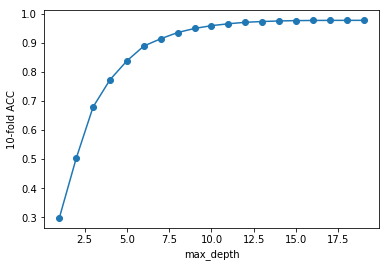

In [40]:
maxDepth = range(1,20)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

<font color='blue'>Nos vamos a centrar en el valor de accuracy para las muestras de test, y para ello utilizamos el valor de "max_depth" optimo obtenido en el paso anterior.</font>

In [41]:
maxDepthOptimo = grid.best_params_['max_depth']
rfModel = RandomForestRegressor(max_depth=19,n_estimators=200,max_features='sqrt').fit(Xs_train,y_train)

print("Test: ",rfModel.score(Xs_test,y_test))

Test:  0.977682652494


<font color='blue'>Muy buen resultado, mejor en 0,003 que el obtenido para el arbol de decisión. Vamos a ver la gráfica comparativa entre los valores predichos y los reales:</font>

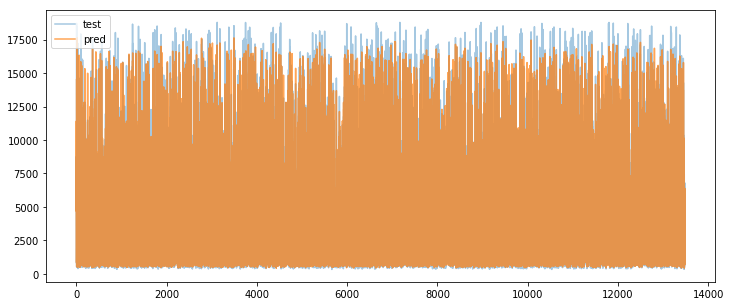

In [42]:
ytestRF = rfModel.predict(Xs_test)

plt.figure(figsize=(12,5))

plt.plot(y_test,label='test',alpha=0.4)
plt.plot(ytestRF,label='pred',alpha=0.7)
plt.legend()
plt.show()

<font color='blue'>En este modelo el error es muy bajo tal y como podemos ver por la puntuación (.score). 
    
La gráfica para el conjunto de test evidencia que el precio que predice el modelo se ajusta realmente bien al precio real.
  
Pero vamos a compararlo con otros modelos como parte de la práctica.</font>

### Boosted Trees 

El entrenamiento del algoritmo de boosting requiere fijar tres parámetros libres:

- Número de iteraciones - Niterations
- Tasa de aprendizaje ($\alpha$) - learningRate
- Complejidad del árbol: *max_depth*

Se podría hacer una búsqueda sobre los tres parámetros conjuntamente mediante GridSearchCV, sin embargo, es muy costoso computacionalmente, con lo que es más sencillo aplicar una optimización secuencial: se prueban distintos valores de los parámetros libres, se fijan los óptimos y se busca sobre el resto.

En este caso vamos a fijar "max_depth=3"

In [43]:
Niterations = [25,50,100,500,700,900]
learningRate = [0.1,0.05,0.01]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 10)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.980
best parameters: {'learning_rate': 0.1, 'n_estimators': 900}


<font color='blue'> Representemos el error que estamos cometiendo para los distintos valores de los parámetros libres</font>

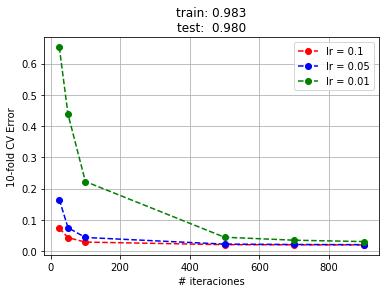

In [44]:
bt = GradientBoostingRegressor(random_state=0, max_depth=3, learning_rate= 0.1, n_estimators= 900)
bt.fit(Xs_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('10-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(Xs_train,y_train),bt.score(Xs_test,y_test)))
plt.grid()
plt.show()

<font color='blue'>Las prestaciones son incluso mejores que con respecto a los casos anteriores y no veo necesario replicar el análisis anterior aumentando el valor de la complejidad.</font>

<font color='blue'>En éste punto representamos la importancia de las variables</font>
<font color='green'>

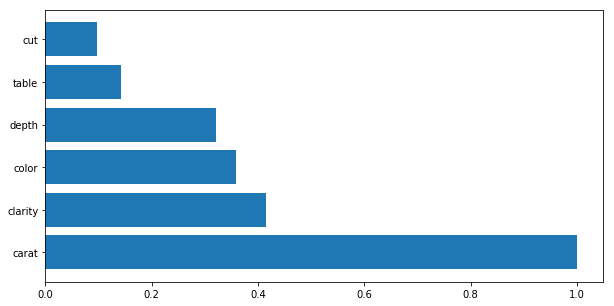

In [45]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.barh(range(Xs_train.shape[1]),importances[indices])
plt.yticks(range(Xs_train.shape[1]),features[indices])
plt.show()

<font color='blue'>Es clara la influencia de carat a la hora de determinar el precio.</font>

<font color='blue'>Representamos la dependencia de cada característica con la variable target</font>
<font color='green'>

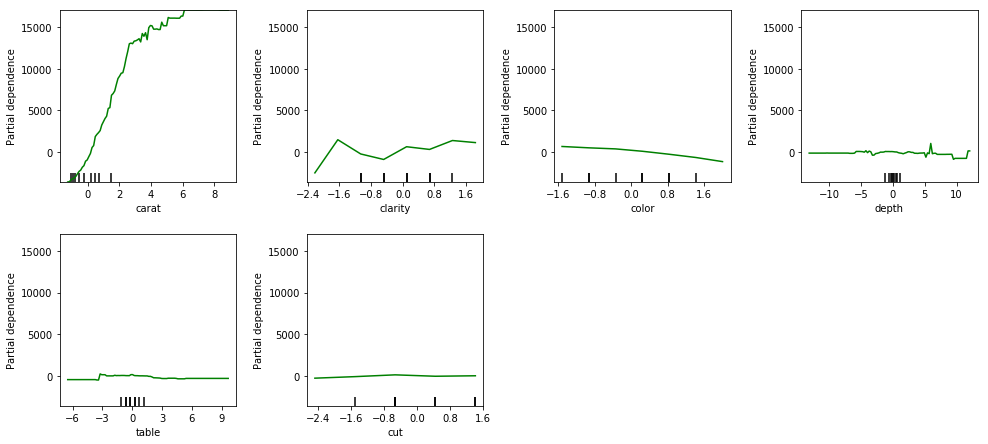

In [46]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig, ax = plot_partial_dependence(bt, Xs_train, indices, feature_names=features,
                             percentiles=(0.0, 1.0), n_cols = 4)
fig.set_size_inches(15, 10)
plt.show()

<font color='blue'>De nuevo es clara la influencia de carat a la hora de determinar el precio.</font>

### SVM Kernel RBF 

<font color='blue'> Por último probamos analizando las máquinas de vectores soporte en regresión, en ocasiones denominadas *Support Vector Regression*.
    
Estan hechos ya todos los calculos previos, incluido el paso por el Scaler.</font>

In [ ]:
from sklearn.svm import SVR
vectorC = np.logspace(-2, 2, 9)
vectorG = np.logspace(-5, 1, 9)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(Xs_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


best mean cross-validation score: 0.926
best parameters: {'C': 100.0, 'gamma': 0.056234132519034911}


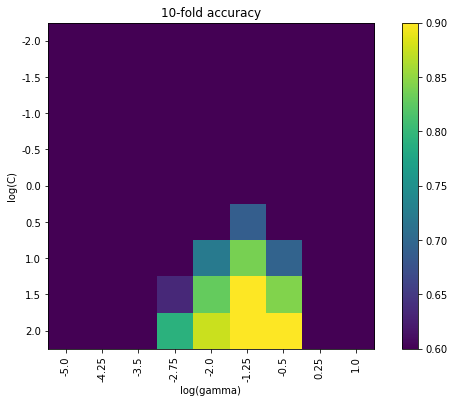

In [50]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('10-fold accuracy')
plt.show()

In [51]:
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmM = SVC(kernel='rbf',gamma = Gopt, C = Copt).fit(Xs_train,y_train)
print('Acc (TEST): %0.2f'%svmM.score(Xs_test,y_test))

Acc (TEST): 0.04


<font color='blue'>Este último resultado es muy malo, pero creo que se debe a que no ha terminado correctamente el primer paso. En cualquier caso llevo varios días ejecutándolo por lo que no voy a repetirlo. Yo creo que no va a mejorar el resultado de 0.98 obtenido en boosted trees.</font>